Hello! I will be moving to boston in the coming fall, and so I wanted my project to be somewhat related to that city in the hopes that I might get some undeful information for my time living there. Specifically, I decided that I wanted to try and predict the amount of time a bluebike (the rental bike service in boston) ride would take based on a bunch of information about the bike ride. Lets see how it goes.

Importing Libraries and stuff

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc.distributions.transforms as tr

GEtting my data and combining the different spreadsheets together

In [2]:
import os

# Define the folder and file pattern
folder_path = '2024'
file_pattern = '2024{:02d}-bluebikes-tripdata.csv'

# Combine all CSV files into one dataframe
dfs = []
for month in range(1, 13):
    file_path = os.path.join(folder_path, file_pattern.format(month))
    dfs.append(pd.read_csv(file_path))

combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,D2F4A4783B230A84,electric_bike,2024-01-31 12:16:49,2024-01-31 12:21:02,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362357,-71.088163,42.365070,-71.103100,member
1,D305CEFFD4558633,classic_bike,2024-01-12 08:14:16,2024-01-12 08:19:48,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member
2,02009BB4EBA0D1F6,electric_bike,2024-01-29 15:00:05,2024-01-29 15:05:47,One Memorial Drive,M32053,Kennedy-Longfellow School 158 Spring St,M32065,42.361697,-71.080273,42.369553,-71.085790,member
3,04C230C1C39071F7,classic_bike,2024-01-09 16:33:40,2024-01-09 17:00:41,Ames St at Main St,M32037,Brookline Town Hall,K32005,42.362500,-71.088220,42.333765,-71.120464,member
4,CEAFE67E28B43852,classic_bike,2024-01-23 10:19:21,2024-01-23 10:31:39,Mass Ave T Station,C32063,Chinatown T Stop,D32019,42.341356,-71.083370,42.352409,-71.062679,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751785,D02800DF593AFDC5,classic_bike,2024-12-24 16:28:11.746,2024-12-24 16:42:04.014,Elevate at One Leighton,M32092,MIT Carleton St at Amherst St,M32070,42.369931,-71.073526,42.360542,-71.086698,member
4751786,84E40AD1389B426A,electric_bike,2024-12-10 18:58:36.519,2024-12-10 19:02:19.578,Park Plaza at Charles St S.,D32042,Columbus Ave at W. Canton St,C32077,42.351828,-71.067811,42.344742,-71.076482,member
4751787,D376AC23CD592C8C,classic_bike,2024-12-10 06:49:55.046,2024-12-10 07:03:10.467,Tremont St at W. Dedham St,C32060,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,B32003,42.342549,-71.074214,42.337417,-71.102861,member
4751788,2604733C8EAF22A6,classic_bike,2024-12-15 18:57:36.149,2024-12-15 18:59:07.816,Tremont St at W. Dedham St,C32060,Columbus Ave at W. Canton St,C32077,42.342549,-71.074214,42.344742,-71.076482,member


That's a lot of columns. Here are some more libraries

In [ ]:
import requests
import tqdm
import datetime as dt
import time
import json

I thought that weather data could be useful. Just thinking about it, if its really windy or really rainy or something that could increase the trip duration. I had a hard time getting all of this data together.

In [4]:
data = combined_df.copy()
data['started_at'] = data['started_at'].str.split('.').str[0]
data["started_at"] = pd.to_datetime(data["started_at"], errors='coerce')

# Drop rows with invalid datetime values if necessary
data = data.dropna(subset=["started_at"])
data["rounded_time"] = data["started_at"].dt.round("H")
data["date_str"] = data["rounded_time"].dt.strftime("%Y-%m-%d")

#cache for weather data
weather_cache = {}

def fetch_weather(lat, lon, date_str):
    key = (round(lat, 1), round(lon, 1), date_str)
    if key in weather_cache:
        return weather_cache[key]

    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={date_str}&end_date={date_str}"
        "&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m,"
        "relative_humidity_2m,visibility"
        "&timezone=America/New_York"
    )
    try:
        response = requests.get(url)
        response.raise_for_status()
        json_data = response.json()
        if "hourly" not in json_data:
            print(f"No 'hourly' in response for {key}: {json_data}")
            return None
        weather_cache[key] = json_data["hourly"]
        return json_data["hourly"]
    except Exception as e:
        print(f"Error fetching weather data for {key}: {e}")
        return None

C:\Users\Candice\AppData\Local\Temp\ipykernel_61752\997120286.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["rounded_time"] = data["started_at"].dt.round("H")


Now I have one hour buckets for time

In [5]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rounded_time,date_str
0,D2F4A4783B230A84,electric_bike,2024-01-31 12:16:49,2024-01-31 12:21:02,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362357,-71.088163,42.365070,-71.103100,member,2024-01-31 12:00:00,2024-01-31
1,D305CEFFD4558633,classic_bike,2024-01-12 08:14:16,2024-01-12 08:19:48,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member,2024-01-12 08:00:00,2024-01-12
2,02009BB4EBA0D1F6,electric_bike,2024-01-29 15:00:05,2024-01-29 15:05:47,One Memorial Drive,M32053,Kennedy-Longfellow School 158 Spring St,M32065,42.361697,-71.080273,42.369553,-71.085790,member,2024-01-29 15:00:00,2024-01-29
3,04C230C1C39071F7,classic_bike,2024-01-09 16:33:40,2024-01-09 17:00:41,Ames St at Main St,M32037,Brookline Town Hall,K32005,42.362500,-71.088220,42.333765,-71.120464,member,2024-01-09 17:00:00,2024-01-09
4,CEAFE67E28B43852,classic_bike,2024-01-23 10:19:21,2024-01-23 10:31:39,Mass Ave T Station,C32063,Chinatown T Stop,D32019,42.341356,-71.083370,42.352409,-71.062679,member,2024-01-23 10:00:00,2024-01-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751785,D02800DF593AFDC5,classic_bike,2024-12-24 16:28:11,2024-12-24 16:42:04.014,Elevate at One Leighton,M32092,MIT Carleton St at Amherst St,M32070,42.369931,-71.073526,42.360542,-71.086698,member,2024-12-24 16:00:00,2024-12-24
4751786,84E40AD1389B426A,electric_bike,2024-12-10 18:58:36,2024-12-10 19:02:19.578,Park Plaza at Charles St S.,D32042,Columbus Ave at W. Canton St,C32077,42.351828,-71.067811,42.344742,-71.076482,member,2024-12-10 19:00:00,2024-12-10
4751787,D376AC23CD592C8C,classic_bike,2024-12-10 06:49:55,2024-12-10 07:03:10.467,Tremont St at W. Dedham St,C32060,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,B32003,42.342549,-71.074214,42.337417,-71.102861,member,2024-12-10 07:00:00,2024-12-10
4751788,2604733C8EAF22A6,classic_bike,2024-12-15 18:57:36,2024-12-15 18:59:07.816,Tremont St at W. Dedham St,C32060,Columbus Ave at W. Canton St,C32077,42.342549,-71.074214,42.344742,-71.076482,member,2024-12-15 19:00:00,2024-12-15


In [6]:
data["round_lat"] = data["start_lat"].round(1)
data["round_lng"] = data["start_lng"].round(1)
unique_keys = data[["round_lat", "round_lng", "date_str"]].drop_duplicates()
unique_keys

,round_lat,round_lng,date_str
0,42.4,-71.1,2024-01-31
1,42.4,-71.1,2024-01-12
2,42.4,-71.1,2024-01-29
3,42.4,-71.1,2024-01-09
4,42.3,-71.1,2024-01-23
...,...,...,...
4655251,42.5,-70.9,2024-12-30
4669058,42.5,-70.9,2024-12-31
4679081,42.2,-70.9,2024-12-06
4681099,42.3,-71.2,2025-01-01


And now I also have buckets for latitude and logitude down to the 10ths place.

Asking for the weather data

In [7]:
weather_results = {}
print("Fetching weather data...")
for _, row in tqdm.tqdm(unique_keys.iterrows(), total=unique_keys.shape[0]):
    lat, lon, date_str = row["round_lat"], row["round_lng"], row["date_str"]
    weather = fetch_weather(lat, lon, date_str)
    key = (round(lat, 1), round(lon, 1), date_str)
    weather_results[key] = weather

Fetching weather data...


 78%|███████▊  | 2031/2616 [37:45<26:38:05, 163.91s/it]

Error fetching weather data for (42.3, -71.2, '2024-10-25'): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|██████████| 2616/2616 [44:43<00:00,  1.03s/it]    


And applying it to the dataframe (sidenote I really like this tqdm library, thats what I use for the progress bars)

In [8]:
# Assign weather data back to rows
print("Mapping weather data to rides...")
weather_data_rows = []
for _, row in tqdm.tqdm(data.iterrows(), total=data.shape[0]):
    key = (round(row["start_lat"], 1), round(row["start_lng"], 1), row["date_str"])
    weather = weather_results.get(key)
    if weather:
        # Find the closest hour in hourly data
        hour_idx = row["rounded_time"].hour
        try:
            weather_data_rows.append({
                "rounded_time": row["rounded_time"],
                "temperature": weather["temperature_2m"][hour_idx],
                "precipitation": weather["precipitation"][hour_idx],
                "wind_speed": weather["wind_speed_10m"][hour_idx],
                "wind_direction": weather["winddirection_10m"][hour_idx],
                "humidity": weather["relative_humidity_2m"][hour_idx],
                "visibility": weather["visibility"][hour_idx]
            })
        except IndexError:
            # Sometimes hourly data might not be complete
            weather_data_rows.append({
                "rounded_time": row["rounded_time"],
                "temperature": None,
                "precipitation": None,
                "wind_speed": None,
                "wind_direction": None,
                "humidity": None,
                "visibility": None
            })
    else:
        weather_data_rows.append({
            "rounded_time": row["rounded_time"],
            "temperature": None,
            "precipitation": None,
            "wind_speed": None,
            "wind_direction": None,
            "humidity": None,
            "visibility": None
        })

# Merge weather data
weather_df = pd.DataFrame(weather_data_rows)
data = data.reset_index(drop=True)
data = pd.concat([data, weather_df.drop(columns=["rounded_time"])], axis=1)

Mapping weather data to rides...


100%|██████████| 4751790/4751790 [11:23<00:00, 6949.86it/s] 


In [9]:
no_weather = data[(data['temperature'].isna())].copy()

In [10]:
weather_cache_2 = {}
no_weather["round_lat"] = no_weather["start_lat"].round(1)
no_weather["round_lng"] = no_weather["start_lng"].round(1)
unique_keys = no_weather[["round_lat", "round_lng", "date_str"]].drop_duplicates()
unique_keys

,round_lat,round_lng,date_str
2234857,42.4,-71.2,2024-07-12
3525438,42.4,-71.2,2024-09-02
3599855,42.3,-71.2,2024-10-25


One more round of fetching weather data for every row that didn't work for one reason or another the first time.

In [11]:
weather_results = {}
print("Fetching weather data...")
for _, row in tqdm.tqdm(unique_keys.iterrows(), total=unique_keys.shape[0]):
    lat, lon, date_str = row["round_lat"], row["round_lng"], row["date_str"]
    weather = fetch_weather(lat, lon, date_str)
    key = (round(lat, 1), round(lon, 1), date_str)
    weather_results[key] = weather

Fetching weather data...


100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


In [12]:
# Assign weather data back to rows
print("Mapping weather data to rides...")
weather_data_rows = []
for _, row in tqdm.tqdm(no_weather.iterrows(), total=no_weather.shape[0]):
    key = (round(row["start_lat"], 1), round(row["start_lng"], 1), row["date_str"])
    weather = weather_results.get(key)
    if weather:
        # Find the closest hour in hourly data
        hour_idx = row["rounded_time"].hour
        try:
            weather_data_rows.append({
                "rounded_time": row["rounded_time"],
                "temperature": weather["temperature_2m"][hour_idx],
                "precipitation": weather["precipitation"][hour_idx],
                "wind_speed": weather["wind_speed_10m"][hour_idx],
                "wind_direction": weather["winddirection_10m"][hour_idx],
                "humidity": weather["relative_humidity_2m"][hour_idx],
                "visibility": weather["visibility"][hour_idx]
            })
        except IndexError:
            # Sometimes hourly data might not be complete
            weather_data_rows.append({
                "rounded_time": row["rounded_time"],
                "temperature": None,
                "precipitation": None,
                "wind_speed": None,
                "wind_direction": None,
                "humidity": None,
                "visibility": None
            })
    else:
        weather_data_rows.append({
            "rounded_time": row["rounded_time"],
            "temperature": None,
            "precipitation": None,
            "wind_speed": None,
            "wind_direction": None,
            "humidity": None,
            "visibility": None
        })

# Merge weather data
weather_df_2 = pd.DataFrame(weather_data_rows)
no_weather = no_weather.reset_index(drop=True)
no_weather = pd.concat([no_weather, weather_df_2.drop(columns=["rounded_time"])], axis=1)

Mapping weather data to rides...


100%|██████████| 203/203 [00:00<00:00, 5764.10it/s]


Put the data from the second round back into the dataframe.

In [13]:
# Remove columns with all NaN or None values
no_weather = no_weather.dropna(axis=1, how='all')
data = data.dropna(axis=1, how='all')
no_weather = no_weather.drop(columns=['round_lat', 'round_lng'])

# Remove duplicate columns, keeping the first occurrence
no_weather = no_weather.loc[:, ~no_weather.columns.duplicated()]

In [ ]:
# Update rows in 'data' with the corresponding rows from 'no_weather'
data.update(no_weather)

In [ ]:
# Show rows with missing weather data
data[data['temperature'].isna()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,rounded_time,date_str,round_lat,round_lng,temperature,precipitation,wind_speed,wind_direction,humidity
2234857,01B348D323DD397B,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,NaN,NaN,Somerville Hospital,S32052,42.450000,-71.220000,...,casual,2024-07-12 12:00:00,2024-07-12,42.4,-71.2,NaN,NaN,NaN,NaN,NaN
3525438,E677E53B9402C99C,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,NaN,NaN,Dana Park,M32030,42.450000,-71.230000,...,member,2024-09-02 14:00:00,2024-09-02,42.4,-71.2,NaN,NaN,NaN,NaN,NaN
3599855,4C17F1F10924F5F3,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15.800,Boston College T,N32009,Union Square - Brighton Ave at Cambridge St,A32001,42.339879,-71.167089,...,member,2024-10-25 19:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
3601820,BE42077B4A102BFE,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52.954,Chestnut Hill Ave at Ledgemere Rd,B32038,Newbury St at Hereford St,B32000,42.343706,-71.153257,...,member,2024-10-25 12:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
3604218,12FD2246241E530B,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26.922,Boston College T,N32009,Oak Square - 615 Washington St,D32031,42.339879,-71.167089,...,casual,2024-10-25 13:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154986,DBD749E76EBC6C79,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24.832,Commonwealth Ave at Chiswick Rd,D32033,Harvard Stadium: N. Harvard St at Soldiers Fie...,A32052,42.340246,-71.151688,...,member,2024-10-25 12:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
4155855,1B88215F551CF1E8,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46.628,Brighton Center - Washington St at Cambridge St,D32028,Central Square at Mass Ave / Essex St,M32011,42.348949,-71.150272,...,member,2024-10-25 21:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
4156030,75BD823B5F5D0F15,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11.863,Boston College T,N32009,Kennedy-Longfellow School 158 Spring St,M32065,42.339879,-71.167089,...,member,2024-10-25 20:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN
4157491,749CE03E73828799,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51.485,Chestnut Hill Ave at Ledgemere Rd,B32038,Central Square at Mass Ave / Essex St,M32011,42.343706,-71.153257,...,casual,2024-10-25 14:00:00,2024-10-25,42.3,-71.2,NaN,NaN,NaN,NaN,NaN


In [16]:
no_weather

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rounded_time,date_str,temperature,precipitation,wind_speed,wind_direction,humidity
0,01B348D323DD397B,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,NaN,NaN,Somerville Hospital,S32052,42.450000,-71.220000,42.390413,-71.108571,casual,2024-07-12 12:00:00,2024-07-12,NaN,NaN,NaN,NaN,NaN
1,E677E53B9402C99C,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,NaN,NaN,Dana Park,M32030,42.450000,-71.230000,42.361780,-71.108100,member,2024-09-02 14:00:00,2024-09-02,NaN,NaN,NaN,NaN,NaN
2,4C17F1F10924F5F3,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15.800,Boston College T,N32009,Union Square - Brighton Ave at Cambridge St,A32001,42.339879,-71.167089,42.353334,-71.137313,member,2024-10-25 19:00:00,2024-10-25,9.8,0.0,9.9,177.0,70.0
3,BE42077B4A102BFE,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52.954,Chestnut Hill Ave at Ledgemere Rd,B32038,Newbury St at Hereford St,B32000,42.343706,-71.153257,42.348717,-71.085954,member,2024-10-25 12:00:00,2024-10-25,12.6,0.0,3.5,9.0,52.0
4,12FD2246241E530B,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26.922,Boston College T,N32009,Oak Square - 615 Washington St,D32031,42.339879,-71.167089,42.350570,-71.166491,casual,2024-10-25 13:00:00,2024-10-25,13.6,0.0,1.7,283.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,DBD749E76EBC6C79,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24.832,Commonwealth Ave at Chiswick Rd,D32033,Harvard Stadium: N. Harvard St at Soldiers Fie...,A32052,42.340246,-71.151688,42.368019,-71.124200,member,2024-10-25 12:00:00,2024-10-25,12.6,0.0,3.5,9.0,52.0
199,1B88215F551CF1E8,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46.628,Brighton Center - Washington St at Cambridge St,D32028,Central Square at Mass Ave / Essex St,M32011,42.348949,-71.150272,42.365070,-71.103100,member,2024-10-25 21:00:00,2024-10-25,8.2,0.0,10.2,225.0,83.0
200,75BD823B5F5D0F15,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11.863,Boston College T,N32009,Kennedy-Longfellow School 158 Spring St,M32065,42.339879,-71.167089,42.369553,-71.085790,member,2024-10-25 20:00:00,2024-10-25,8.7,0.0,9.9,201.0,78.0
201,749CE03E73828799,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51.485,Chestnut Hill Ave at Ledgemere Rd,B32038,Central Square at Mass Ave / Essex St,M32011,42.343706,-71.153257,42.365070,-71.103100,casual,2024-10-25 14:00:00,2024-10-25,14.4,0.0,3.5,249.0,48.0


In [17]:
data2 = data.copy()
#remove rows with missing weather data
data2 = data2[~data2['temperature'].isna()]
#add rows with missing weather data to the end of the dataframe
data2 = pd.concat([data2, no_weather], ignore_index=True)

In [18]:
data = data2

In [19]:
# check if there are any missing values in the weather data
data[data['temperature'].isna()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,rounded_time,date_str,round_lat,round_lng,temperature,precipitation,wind_speed,wind_direction,humidity
4751587,01B348D323DD397B,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,NaN,NaN,Somerville Hospital,S32052,42.45,-71.22,...,casual,2024-07-12 12:00:00,2024-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4751588,E677E53B9402C99C,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,NaN,NaN,Dana Park,M32030,42.45,-71.23,...,member,2024-09-02 14:00:00,2024-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Weird issues with missing data that I had to fix

In [20]:
# Drop rows with missing data
data.dropna(subset=['start_station_name', 'end_station_name'], inplace=True)

In [21]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,rounded_time,date_str,round_lat,round_lng,temperature,precipitation,wind_speed,wind_direction,humidity
0,01B348D323DD397B,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,Ames St at Main St,M32037,Somerville Hospital,S32052,42.450000,-71.220000,...,casual,2024-07-12 12:00:00,2024-07-12,42.4,-71.1,0.7,0.0,5.8,210.0,55.0
1,E677E53B9402C99C,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,Ames St at Main St,M32037,Dana Park,M32030,42.450000,-71.230000,...,member,2024-09-02 14:00:00,2024-09-02,42.4,-71.1,-1.1,0.0,8.7,277.0,88.0
2,4C17F1F10924F5F3,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15.800,Boston College T,N32009,Union Square - Brighton Ave at Cambridge St,A32001,42.339879,-71.167089,...,member,2024-10-25 19:00:00,2024-10-25,42.4,-71.1,9.8,0.0,9.9,177.0,70.0
3,BE42077B4A102BFE,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52.954,Chestnut Hill Ave at Ledgemere Rd,B32038,Newbury St at Hereford St,B32000,42.343706,-71.153257,...,member,2024-10-25 12:00:00,2024-10-25,42.4,-71.1,12.6,0.0,3.5,9.0,52.0
4,12FD2246241E530B,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26.922,Boston College T,N32009,Oak Square - 615 Washington St,D32031,42.339879,-71.167089,...,casual,2024-10-25 13:00:00,2024-10-25,42.3,-71.1,13.6,0.0,1.7,283.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751785,DBD749E76EBC6C79,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24.832,Commonwealth Ave at Chiswick Rd,D32033,Harvard Stadium: N. Harvard St at Soldiers Fie...,A32052,42.340246,-71.151688,...,member,2024-10-25 12:00:00,2024-10-25,NaN,NaN,12.6,0.0,3.5,9.0,52.0
4751786,1B88215F551CF1E8,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46.628,Brighton Center - Washington St at Cambridge St,D32028,Central Square at Mass Ave / Essex St,M32011,42.348949,-71.150272,...,member,2024-10-25 21:00:00,2024-10-25,NaN,NaN,8.2,0.0,10.2,225.0,83.0
4751787,75BD823B5F5D0F15,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11.863,Boston College T,N32009,Kennedy-Longfellow School 158 Spring St,M32065,42.339879,-71.167089,...,member,2024-10-25 20:00:00,2024-10-25,NaN,NaN,8.7,0.0,9.9,201.0,78.0
4751788,749CE03E73828799,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51.485,Chestnut Hill Ave at Ledgemere Rd,B32038,Central Square at Mass Ave / Essex St,M32011,42.343706,-71.153257,...,casual,2024-10-25 14:00:00,2024-10-25,NaN,NaN,14.4,0.0,3.5,249.0,48.0


In [22]:
#check for missing values anywhere in the dataframe
data.isna().sum()

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name        0
end_station_id        390
start_lat               0
start_lng               0
end_lat                 0
end_lng                 0
member_casual           0
rounded_time            0
date_str                0
round_lat             200
round_lng             200
temperature             0
precipitation           0
wind_speed              0
wind_direction          0
humidity                0
dtype: int64

Phew, we may be done data processing!

In [ ]:
#download the data to a csv file
data.to_csv("data.csv", index=False)

In [7]:
data = pd.read_csv("data.csv")

In [4]:
#drop the columns that we don't need
data.drop(columns=['start_station_id', 'end_station_id'], inplace=True)

OK! Now I decided to get elevation data because biking uphill is hard

In [31]:
#Altitude Gain

def get_elevation_opentopo(lat, lon):
    url = (
        "https://api.opentopodata.org/v1/test-dataset?locations="
        f"{lat},{lon}&fields=elevation"
    )
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        resp = r.json()
        # the "results" list will usually have a single dict
        return resp['results'][0]['elevation']
    except Exception as e:
        print(f"OpenTopo error for {lat}, {lon}: {e}")
        return None


In [29]:
get_elevation_opentopo(42.45, -71.22)

77.73699951171875

In [ ]:
# Create a dataframe to store station elevations
station_elevations = {}

In [33]:
import time

# Track the number of API calls made
api_call_count = 0
daily_limit = 1000

def get_station_elevation(station_name, lat, lon):
    global api_call_count

    if station_name not in station_elevations or station_elevations[station_name] is None:
        # Check if the daily limit has been reached
        if api_call_count >= daily_limit:
            print("Daily API call limit reached. Cannot fetch more elevations.")
            return None

        # Fetch elevation data
        elevation = get_elevation_opentopo(lat, lon)
        station_elevations[station_name] = elevation

        # Increment the API call count and add a delay to respect the rate limit
        api_call_count += 1
        time.sleep(1)

    return station_elevations[station_name]

station_elevations

{'Ames St at Main St': 77.73699951171875,
 'Somerville Hospital': 52.13851547241211,
 'Dana Park': 51.301639556884766,
 'Boston College T': 62.21441650390625,
 'Union Square - Brighton Ave at Cambridge St': 56.843894958496094,
 'Chestnut Hill Ave at Ledgemere Rd': 59.655025482177734,
 'Newbury St at Hereford St': None,
 'Oak Square - 615 Washington St': 62.494972229003906,
 'Washington St at Brock St': 61.222625732421875,
 'Hyde Square - Centre St at Perkins St': None,
 'Mass Ave at Albany St': 49.02570343017578,
 'Brighton Center - Washington St at Cambridge St': 59.25019073486328,
 'Silber Way': 49.50589370727539,
 'Spring St at Powell St': 59.219505310058594,
 'Forest Hills': None,
 'Commonwealth Ave at Agganis Way': 53.19363784790039,
 'Swan Place at Minuteman Bikeway': 61.926116943359375,
 'Martha Eliot Health Center': None,
 'Commonwealth Ave at Chiswick Rd': 59.229976654052734,
 'Beacon St at Tappan St': None,
 'Cleveland Circle': 58.86088943481445,
 'Auburndale': 78.34441375732

In [13]:
get_station_elevation("Ames St at Main St",	42.450000,	-71.220000)

77.73699951171875

In [34]:
for _, row in data.iterrows():
    # Check and add start station elevation if not already in the dictionary
    get_station_elevation(row['start_station_name'], row['start_lat'], row['start_lng'])
    
    # Check and add end station elevation if not already in the dictionary
    station_elevations[row['end_station_name']] = get_station_elevation(row['end_station_name'], row['end_lat'], row['end_lng'])

In [35]:
station_elevations

{'Ames St at Main St': 77.73699951171875,
 'Somerville Hospital': 52.13851547241211,
 'Dana Park': 51.301639556884766,
 'Boston College T': 62.21441650390625,
 'Union Square - Brighton Ave at Cambridge St': 56.843894958496094,
 'Chestnut Hill Ave at Ledgemere Rd': 59.655025482177734,
 'Newbury St at Hereford St': 46.61655807495117,
 'Oak Square - 615 Washington St': 62.494972229003906,
 'Washington St at Brock St': 61.222625732421875,
 'Hyde Square - Centre St at Perkins St': 50.599632263183594,
 'Mass Ave at Albany St': 49.02570343017578,
 'Brighton Center - Washington St at Cambridge St': 59.25019073486328,
 'Silber Way': 49.50589370727539,
 'Spring St at Powell St': 59.219505310058594,
 'Forest Hills': 50.87810516357422,
 'Commonwealth Ave at Agganis Way': 53.19363784790039,
 'Swan Place at Minuteman Bikeway': 61.926116943359375,
 'Martha Eliot Health Center': 49.152870178222656,
 'Commonwealth Ave at Chiswick Rd': 59.229976654052734,
 'Beacon St at Tappan St': 56.686683654785156,
 

In [36]:
len(station_elevations)

541

In [37]:
# append elevation to data
for station_name, elevation in station_elevations.items():
    if elevation is not None:
        data.loc[data['start_station_name'] == station_name, 'start_station_elevation'] = elevation
        data.loc[data['end_station_name'] == station_name, 'end_station_elevation'] = elevation

In [38]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,...,date_str,round_lat,round_lng,temperature,precipitation,wind_speed,wind_direction,humidity,start_station_elevation,end_station_elevation
0,01B348D323DD397B,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,Ames St at Main St,Somerville Hospital,42.450000,-71.220000,42.390413,-71.108571,...,2024-07-12,42.4,-71.1,0.7,0.0,5.8,210.0,55.0,77.737000,52.138515
1,E677E53B9402C99C,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,Ames St at Main St,Dana Park,42.450000,-71.230000,42.361780,-71.108100,...,2024-09-02,42.4,-71.1,-1.1,0.0,8.7,277.0,88.0,77.737000,51.301640
2,4C17F1F10924F5F3,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15.800,Boston College T,Union Square - Brighton Ave at Cambridge St,42.339879,-71.167089,42.353334,-71.137313,...,2024-10-25,42.4,-71.1,9.8,0.0,9.9,177.0,70.0,62.214417,56.843895
3,BE42077B4A102BFE,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52.954,Chestnut Hill Ave at Ledgemere Rd,Newbury St at Hereford St,42.343706,-71.153257,42.348717,-71.085954,...,2024-10-25,42.4,-71.1,12.6,0.0,3.5,9.0,52.0,59.655025,46.616558
4,12FD2246241E530B,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26.922,Boston College T,Oak Square - 615 Washington St,42.339879,-71.167089,42.350570,-71.166491,...,2024-10-25,42.3,-71.1,13.6,0.0,1.7,283.0,50.0,62.214417,62.494972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742631,DBD749E76EBC6C79,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24.832,Commonwealth Ave at Chiswick Rd,Harvard Stadium: N. Harvard St at Soldiers Fie...,42.340246,-71.151688,42.368019,-71.124200,...,2024-10-25,NaN,NaN,12.6,0.0,3.5,9.0,52.0,59.229977,54.683533
4742632,1B88215F551CF1E8,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46.628,Brighton Center - Washington St at Cambridge St,Central Square at Mass Ave / Essex St,42.348949,-71.150272,42.365070,-71.103100,...,2024-10-25,NaN,NaN,8.2,0.0,10.2,225.0,83.0,59.250191,50.389523
4742633,75BD823B5F5D0F15,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11.863,Boston College T,Kennedy-Longfellow School 158 Spring St,42.339879,-71.167089,42.369553,-71.085790,...,2024-10-25,NaN,NaN,8.7,0.0,9.9,201.0,78.0,62.214417,47.033566
4742634,749CE03E73828799,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51.485,Chestnut Hill Ave at Ledgemere Rd,Central Square at Mass Ave / Essex St,42.343706,-71.153257,42.365070,-71.103100,...,2024-10-25,NaN,NaN,14.4,0.0,3.5,249.0,48.0,59.655025,50.389523


That was easier than the weather.

In [ ]:
# Save the data again
data.to_csv("data-with-altitude.csv", index=False)

In [5]:
# Load the data
data = pd.read_csv("data-with-altitude.csv")

In [6]:
#remove unneeded columns
data = data.drop(columns=['round_lat', 'round_lng', 'ride_id','date_str'])

In [7]:
data

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,rounded_time,temperature,precipitation,wind_speed,wind_direction,humidity,start_station_elevation,end_station_elevation
0,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14.747,Ames St at Main St,Somerville Hospital,42.450000,-71.220000,42.390413,-71.108571,casual,2024-07-12 12:00:00,0.7,0.0,5.8,210.0,55.0,77.737000,52.138515
1,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20.564,Ames St at Main St,Dana Park,42.450000,-71.230000,42.361780,-71.108100,member,2024-09-02 14:00:00,-1.1,0.0,8.7,277.0,88.0,77.737000,51.301640
2,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15.800,Boston College T,Union Square - Brighton Ave at Cambridge St,42.339879,-71.167089,42.353334,-71.137313,member,2024-10-25 19:00:00,9.8,0.0,9.9,177.0,70.0,62.214417,56.843895
3,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52.954,Chestnut Hill Ave at Ledgemere Rd,Newbury St at Hereford St,42.343706,-71.153257,42.348717,-71.085954,member,2024-10-25 12:00:00,12.6,0.0,3.5,9.0,52.0,59.655025,46.616558
4,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26.922,Boston College T,Oak Square - 615 Washington St,42.339879,-71.167089,42.350570,-71.166491,casual,2024-10-25 13:00:00,13.6,0.0,1.7,283.0,50.0,62.214417,62.494972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742631,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24.832,Commonwealth Ave at Chiswick Rd,Harvard Stadium: N. Harvard St at Soldiers Fie...,42.340246,-71.151688,42.368019,-71.124200,member,2024-10-25 12:00:00,12.6,0.0,3.5,9.0,52.0,59.229977,54.683533
4742632,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46.628,Brighton Center - Washington St at Cambridge St,Central Square at Mass Ave / Essex St,42.348949,-71.150272,42.365070,-71.103100,member,2024-10-25 21:00:00,8.2,0.0,10.2,225.0,83.0,59.250191,50.389523
4742633,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11.863,Boston College T,Kennedy-Longfellow School 158 Spring St,42.339879,-71.167089,42.369553,-71.085790,member,2024-10-25 20:00:00,8.7,0.0,9.9,201.0,78.0,62.214417,47.033566
4742634,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51.485,Chestnut Hill Ave at Ledgemere Rd,Central Square at Mass Ave / Essex St,42.343706,-71.153257,42.365070,-71.103100,casual,2024-10-25 14:00:00,14.4,0.0,3.5,249.0,48.0,59.655025,50.389523


FEATURE ENGINEERING TIME

In [8]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

Calculate the distance between 2 latitude and longitude points (in kilometers)

In [10]:
haversine(42.335543, -71.150615,42.368019,-71.124200)

np.float64(4.213350152487648)

In [11]:
cleaned_data = data.copy()

Maybe whether its a holiday matters. Idk

In [12]:
# Install the holidays module
%pip install holidays

import holidays

Note: you may need to restart the kernel to use updated packages.


Cleaning up data, removing unnecesary columns, add distance, add day of the week/month/holiday stuff

In [13]:
cleaned_data['elevation_change'] = cleaned_data['end_station_elevation'] - cleaned_data['start_station_elevation']
cleaned_data['distance'] = haversine(
    cleaned_data['start_lat'],
    cleaned_data['start_lng'],
    cleaned_data['end_lat'],
    cleaned_data['end_lng']
).round(3)
cleaned_data['ended_at'] = cleaned_data['ended_at'].str.split('.').str[0]
cleaned_data['duration'] = (pd.to_datetime(cleaned_data['ended_at']) - pd.to_datetime(cleaned_data['started_at'])).dt.total_seconds() / 60.0  # Convert to minutes
cleaned_data['hour_of_day'] = pd.to_datetime(cleaned_data['started_at']).dt.hour
cleaned_data['day_of_week'] = pd.to_datetime(cleaned_data['started_at']).dt.dayofweek #monday=0, sunday=6
cleaned_data['month'] = pd.to_datetime(cleaned_data['started_at']).dt.month

us_holidays = holidays.US(years=2024)
cleaned_data['started_at'] = pd.to_datetime(cleaned_data['started_at'], errors='coerce')

cleaned_data['is_holiday'] = cleaned_data['started_at'].dt.date.apply(
    lambda x: x in us_holidays
)
cleaned_data['is_weekend'] = cleaned_data['started_at'].dt.dayofweek >= 5


In [14]:
cleaned_data

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,start_station_elevation,end_station_elevation,elevation_change,distance,duration,hour_of_day,day_of_week,month,is_holiday,is_weekend
0,electric_bike,2024-07-12 12:17:10,2024-07-12 12:50:14,Ames St at Main St,Somerville Hospital,42.450000,-71.220000,42.390413,-71.108571,casual,...,77.737000,52.138515,-25.598484,11.294,33.066667,12,4,7,False,False
1,electric_bike,2024-09-02 13:37:12,2024-09-02 14:54:20,Ames St at Main St,Dana Park,42.450000,-71.230000,42.361780,-71.108100,member,...,77.737000,51.301640,-26.435360,14.014,77.133333,13,0,9,True,False
2,classic_bike,2024-10-25 19:24:39,2024-10-25 19:43:15,Boston College T,Union Square - Brighton Ave at Cambridge St,42.339879,-71.167089,42.353334,-71.137313,member,...,62.214417,56.843895,-5.370522,2.868,18.600000,19,4,10,False,False
3,classic_bike,2024-10-25 11:33:43,2024-10-25 11:59:52,Chestnut Hill Ave at Ledgemere Rd,Newbury St at Hereford St,42.343706,-71.153257,42.348717,-71.085954,member,...,59.655025,46.616558,-13.038467,5.559,26.150000,11,4,10,False,False
4,classic_bike,2024-10-25 12:46:19,2024-10-25 12:53:26,Boston College T,Oak Square - 615 Washington St,42.339879,-71.167089,42.350570,-71.166491,casual,...,62.214417,62.494972,0.280556,1.190,7.116667,12,4,10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742631,electric_bike,2024-10-25 12:14:37,2024-10-25 12:26:24,Commonwealth Ave at Chiswick Rd,Harvard Stadium: N. Harvard St at Soldiers Fie...,42.340246,-71.151688,42.368019,-71.124200,member,...,59.229977,54.683533,-4.546444,3.826,11.783333,12,4,10,False,False
4742632,electric_bike,2024-10-25 21:27:27,2024-10-25 21:44:46,Brighton Center - Washington St at Cambridge St,Central Square at Mass Ave / Essex St,42.348949,-71.150272,42.365070,-71.103100,member,...,59.250191,50.389523,-8.860668,4.271,17.316667,21,4,10,False,False
4742633,electric_bike,2024-10-25 20:03:45,2024-10-25 20:25:11,Boston College T,Kennedy-Longfellow School 158 Spring St,42.339879,-71.167089,42.369553,-71.085790,member,...,62.214417,47.033566,-15.180851,7.451,21.433333,20,4,10,False,False
4742634,classic_bike,2024-10-25 13:46:04,2024-10-25 14:09:51,Chestnut Hill Ave at Ledgemere Rd,Central Square at Mass Ave / Essex St,42.343706,-71.153257,42.365070,-71.103100,casual,...,59.655025,50.389523,-9.265503,4.757,23.783333,13,4,10,False,False


I realized that coordinates and wind direction are near meaningless alone, so I decided I should instead just combine this information into the whether the wind is behind or infront of you

In [15]:
def compute_bearing(lat1, lon1, lat2, lon2):
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_lon = np.radians(lon2 - lon1)
    
    x = np.sin(delta_lon) * np.cos(phi2)
    y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(delta_lon)
    
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360  # Normalize to [0, 360)

In [16]:
#Trip Bearing
cleaned_data['trip_bearing'] = compute_bearing(
    cleaned_data['start_lat'],
    cleaned_data['start_lng'],
    cleaned_data['end_lat'],
    cleaned_data['end_lng']
)
#Vector Components
trip_rad = np.radians(cleaned_data['trip_bearing'])
cleaned_data['trip_bearing_x'] = np.cos(trip_rad)
cleaned_data['trip_bearing_y'] = np.sin(trip_rad)

#Wind vector components
wind_rad = np.radians(cleaned_data['wind_direction'])
cleaned_data['wind_x'] = np.cos(wind_rad)
cleaned_data['wind_y'] = np.sin(wind_rad)

# Wind Opposition (Dot Product)
cleaned_data['wind_opposition'] = (
    cleaned_data['trip_bearing_x'] * cleaned_data['wind_x'] +
    cleaned_data['trip_bearing_y'] * cleaned_data['wind_y']
)


In [17]:
cleaned_data.columns

Index(['rideable_type', 'started_at', 'ended_at', 'start_station_name',
       'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'rounded_time', 'temperature', 'precipitation',
       'wind_speed', 'wind_direction', 'humidity', 'start_station_elevation',
       'end_station_elevation', 'elevation_change', 'distance', 'duration',
       'hour_of_day', 'day_of_week', 'month', 'is_holiday', 'is_weekend',
       'trip_bearing', 'trip_bearing_x', 'trip_bearing_y', 'wind_x', 'wind_y',
       'wind_opposition'],
      dtype='object')

In [18]:
# 1: Drop the raw columns
to_drop = [    'started_at', 'ended_at', 'rounded_time',
    'start_lat', 'start_lng', 'end_lat', 'end_lng',
    'wind_direction', 'start_station_elevation', 'end_station_elevation',
    'trip_bearing']

cleaned_data = cleaned_data.drop(columns=to_drop)


Final input list

In [19]:
cleaned_data.columns

Index(['rideable_type', 'start_station_name', 'end_station_name',
       'member_casual', 'temperature', 'precipitation', 'wind_speed',
       'humidity', 'elevation_change', 'distance', 'duration', 'hour_of_day',
       'day_of_week', 'month', 'is_holiday', 'is_weekend', 'trip_bearing_x',
       'trip_bearing_y', 'wind_x', 'wind_y', 'wind_opposition'],
      dtype='object')

Once I one hot encoded categories, I realized the tensor would have been way too big to handle, So now we are chopping off uncommon stations to save space

This is also a solid idea because less common stations would be harder to find a pattern for because there is less data to go around

In [20]:
for col in ['start_station_name', 'end_station_name']:
    top = cleaned_data[col].value_counts().nlargest(20).index
    cleaned_data[col] = cleaned_data[col].where(cleaned_data[col].isin(top), other='Other')

In [21]:

# 2: Seperate targets and features
target_col = 'duration'
categorical_cols = ['rideable_type', 'member_casual', 'start_station_name', 'end_station_name']
numeric_cols = [
    'distance', 'elevation_change', 'temperature', 'precipitation',
    'wind_speed', 'wind_x', 'wind_y', 'humidity',
    'hour_of_day', 'day_of_week', 'month',
    'is_holiday', 'is_weekend',
    'trip_bearing_x', 'trip_bearing_y', 'wind_opposition'
]

In [22]:

y = cleaned_data[target_col].copy()
X = cleaned_data[categorical_cols + numeric_cols].copy()

In [23]:

# 3: One-hot encode categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


In [24]:

# 4: Normalize numeric columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

Tada! This is about the last time that things went right for me.

In [25]:
X

,distance,elevation_change,temperature,precipitation,wind_speed,wind_x,wind_y,humidity,hour_of_day,day_of_week,...,end_station_name_Landmark Center - Brookline Ave at Park Dr,end_station_name_MIT Pacific St at Purrington St,end_station_name_MIT Stata Center at Vassar St / Main St,end_station_name_MIT Vassar St,end_station_name_MIT at Mass Ave / Amherst St,end_station_name_Mass Ave at Albany St,end_station_name_Mass Ave/Lafayette Square,end_station_name_Other,end_station_name_Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,end_station_name_South Station - 700 Atlantic Ave
0,6.264131,-4.192449,-1.691736,-0.146431,-1.221246,-1.264098,-0.436853,-0.581549,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
1,8.102360,-4.329432,-1.893628,-0.146431,-0.725956,0.282749,-1.095885,1.243161,-0.229365,-1.481860,...,False,False,False,False,False,False,False,True,False,False
2,0.569674,-0.881458,-0.671058,-0.146431,-0.521009,-1.471729,0.302178,0.247864,0.997859,0.566199,...,False,False,False,False,False,False,False,True,False,False
3,2.388305,-2.136577,-0.357003,-0.146431,-1.614061,1.638450,0.441463,-0.747432,-0.638440,0.566199,...,False,False,False,False,False,False,False,True,False,False
4,-0.564351,0.043532,-0.244841,-0.146431,-1.921482,0.444155,-1.071565,-0.858021,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742631,1.217109,-0.746570,-0.357003,-0.146431,-1.614061,1.638450,0.441463,-0.747432,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
4742632,1.517849,-1.452739,-0.850518,-0.146431,-0.469772,-1.015263,-0.713964,0.966690,1.406934,0.566199,...,False,False,False,False,False,False,False,False,False,False
4742633,3.666956,-2.487251,-0.794436,-0.146431,-0.521009,-1.369875,-0.247348,0.690219,1.202397,0.566199,...,False,False,False,False,False,False,False,True,False,False
4742634,1.846297,-1.519004,-0.155111,-0.146431,-1.614061,-0.469207,-1.016988,-0.968609,-0.229365,0.566199,...,False,False,False,False,False,False,False,False,False,False


In [26]:
X.to_pickle("X.pkl")
y.to_pickle("y.pkl")

In [27]:
X = pd.read_pickle("X.pkl")
y = pd.read_pickle("y.pkl")

In [28]:
X

,distance,elevation_change,temperature,precipitation,wind_speed,wind_x,wind_y,humidity,hour_of_day,day_of_week,...,end_station_name_Landmark Center - Brookline Ave at Park Dr,end_station_name_MIT Pacific St at Purrington St,end_station_name_MIT Stata Center at Vassar St / Main St,end_station_name_MIT Vassar St,end_station_name_MIT at Mass Ave / Amherst St,end_station_name_Mass Ave at Albany St,end_station_name_Mass Ave/Lafayette Square,end_station_name_Other,end_station_name_Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,end_station_name_South Station - 700 Atlantic Ave
0,6.264131,-4.192449,-1.691736,-0.146431,-1.221246,-1.264098,-0.436853,-0.581549,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
1,8.102360,-4.329432,-1.893628,-0.146431,-0.725956,0.282749,-1.095885,1.243161,-0.229365,-1.481860,...,False,False,False,False,False,False,False,True,False,False
2,0.569674,-0.881458,-0.671058,-0.146431,-0.521009,-1.471729,0.302178,0.247864,0.997859,0.566199,...,False,False,False,False,False,False,False,True,False,False
3,2.388305,-2.136577,-0.357003,-0.146431,-1.614061,1.638450,0.441463,-0.747432,-0.638440,0.566199,...,False,False,False,False,False,False,False,True,False,False
4,-0.564351,0.043532,-0.244841,-0.146431,-1.921482,0.444155,-1.071565,-0.858021,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742631,1.217109,-0.746570,-0.357003,-0.146431,-1.614061,1.638450,0.441463,-0.747432,-0.433903,0.566199,...,False,False,False,False,False,False,False,True,False,False
4742632,1.517849,-1.452739,-0.850518,-0.146431,-0.469772,-1.015263,-0.713964,0.966690,1.406934,0.566199,...,False,False,False,False,False,False,False,False,False,False
4742633,3.666956,-2.487251,-0.794436,-0.146431,-0.521009,-1.369875,-0.247348,0.690219,1.202397,0.566199,...,False,False,False,False,False,False,False,True,False,False
4742634,1.846297,-1.519004,-0.155111,-0.146431,-1.614061,-0.469207,-1.016988,-0.968609,-0.229365,0.566199,...,False,False,False,False,False,False,False,False,False,False


In [29]:
y

0          33.066667
1          77.133333
2          18.600000
3          26.150000
4           7.116667
             ...    
4742631    11.783333
4742632    17.316667
4742633    21.433333
4742634    23.783333
4742635    14.333333
Name: duration, Length: 4742636, dtype: float64

In [30]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Im sorry that I didn't copy your code Mr. A, the pytorch docs made more sense to me (though maybe i should have copied your code because my code is bery bad)

In [ ]:

# Convert bool to float32 :(
X_numeric = X.copy()
for col in X_numeric.columns:
	if X_numeric[col].dtype == 'bool' or X_numeric[col].dtype == 'object':
		X_numeric[col] = X_numeric[col].astype(float)

# Tensors
X_tensor = torch.tensor(X_numeric.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


I'm deviating slightly from the notes here because I want to use a dataloader

In [32]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

batch_size = 1024
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)

I have no good reason to use this archetecture

In [33]:
import torch.nn as nn

class BluebikeNN(nn.Module):
    def __init__(self, input_dim):
        super(BluebikeNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [36]:
input_dim = X_train.shape[1]
model = BluebikeNN(input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

device = next(model.parameters()).device
best_val_loss = float('inf')

for epoch in range(1, 11):  # e.g. 20 epochs
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_losses.append(criterion(preds, yb).item())

    avg_train = sum(train_losses) / len(train_losses)
    avg_val   = sum(val_losses)   / len(val_losses)

    print(f"Epoch {epoch:02d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")

    # Save best model
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), "best_trip_duration_model.pt")

print("Training complete. Best val loss:", best_val_loss)


Epoch 01 — train loss: 1365.5007, val loss: 1056.5338
Epoch 02 — train loss: 1345.2316, val loss: 1056.3759
Epoch 03 — train loss: 1344.3363, val loss: 1055.6320
Epoch 04 — train loss: 1343.6832, val loss: 1054.7028
Epoch 05 — train loss: 1343.0877, val loss: 1054.4517
Epoch 06 — train loss: 1342.9574, val loss: 1054.5441
Epoch 07 — train loss: 1342.2709, val loss: 1054.1955
Epoch 08 — train loss: 1342.3412, val loss: 1054.3427
Epoch 09 — train loss: 1341.4432, val loss: 1053.8622
Epoch 10 — train loss: 1341.0683, val loss: 1053.7066
Training complete. Best val loss: 1053.7065659392356


In [37]:
model.eval()
with torch.no_grad():
    predictions = model(X_val).squeeze().numpy()


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict all at once
with torch.no_grad():
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    y_pred = model(X_val).squeeze()

# Back to CPU for metrics
y_val_cpu = y_val.cpu().numpy()
y_pred_cpu = y_pred.cpu().numpy()

# Metrics
mse = mean_squared_error(y_val_cpu, y_pred_cpu)
mae = mean_absolute_error(y_val_cpu, y_pred_cpu)
r2 = r2_score(y_val_cpu, y_pred_cpu)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R²:  {r2:.3f}")


Validation MSE: 1054.41
Validation MAE: 7.00
Validation R²:  0.078


All of the above is very yikes. I thought that maybe applying a log to the duration would help deal with really long trips.

In [40]:
y_log = np.log1p(y.values) #log(1 + x) to keep short trips safe

X_tensor2 = torch.tensor(X_numeric.values, dtype=torch.float32)
y_tensor2 = torch.tensor(y_log, dtype=torch.float32).view(-1, 1)

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_tensor2, y_tensor2, test_size=0.2, random_state=42
)
train_loader2 = DataLoader(TensorDataset(X_train2, y_train2),
                          batch_size=1024, shuffle=True,  num_workers=4)
val_loader2   = DataLoader(TensorDataset(X_val2,   y_val2),
                          batch_size=1024, shuffle=False, num_workers=4)

C:\Users\Candice\AppData\Local\Temp\ipykernel_106628\4161355694.py:1: RuntimeWarning: invalid value encountered in log1p
  y_log = np.log1p(y.values) #log(1 + x) to keep short trips safe


In [ ]:
input_dim = X_train2.shape[1]
model2 = BluebikeNN(input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

device = next(model.parameters()).device
best_val_loss = float('inf')

for epoch in range(1, 101):
    model2.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model2.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_losses.append(criterion(preds, yb).item())

    avg_train = sum(train_losses) / len(train_losses)
    avg_val   = sum(val_losses)   / len(val_losses)

    print(f"Epoch {epoch:02d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")

    # Save best model
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), "best_trip_duration_model_2.pt")

print("Training complete. Best val loss:", best_val_loss)


Epoch 01 — train loss: 1340.8157, val loss: 1054.0940
Epoch 02 — train loss: 1340.1641, val loss: 1053.8621
Epoch 03 — train loss: 1339.9325, val loss: 1053.8049
Epoch 04 — train loss: 1339.5025, val loss: 1054.5630
Epoch 05 — train loss: 1338.9686, val loss: 1054.5478
Epoch 06 — train loss: 1338.2473, val loss: 1054.0780
Epoch 07 — train loss: 1338.6244, val loss: 1054.7141
Epoch 08 — train loss: 1337.5786, val loss: 1054.6434
Epoch 09 — train loss: 1337.0416, val loss: 1054.8998
Epoch 10 — train loss: 1336.5807, val loss: 1054.3092
Epoch 11 — train loss: 1336.2135, val loss: 1056.8661
Epoch 12 — train loss: 1335.5114, val loss: 1054.7623
Epoch 13 — train loss: 1335.1347, val loss: 1054.8434
Epoch 14 — train loss: 1334.6132, val loss: 1059.1516
Epoch 15 — train loss: 1334.0250, val loss: 1055.2092
Epoch 16 — train loss: 1332.5265, val loss: 1054.2793
Epoch 17 — train loss: 1332.2364, val loss: 1060.0343
Epoch 18 — train loss: 1330.0248, val loss: 1058.9621
Epoch 19 — train loss: 1329.

In [45]:
model2.eval()
with torch.no_grad():
    log_preds = model2(X_val.to(device)).cpu().numpy().squeeze()
    duration_preds = np.expm1(log_preds)  # reverse log1p

This did not really help. I was told to try dropout layers so now Im doing that.

In [58]:
class DropoutNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(DropoutNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [59]:
# Initialize model
input_dim = X_train.shape[1]
model = DropoutNN(input_dim, dropout_rate=0.3).to('cuda' if torch.cuda.is_available() else 'cpu')
device = next(model.parameters()).device

# Optimizer & loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
best_val_loss = float('inf')
for epoch in range(1, 101):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_losses.append(criterion(preds, yb).item())

    avg_train = sum(train_losses) / len(train_losses)
    avg_val = sum(val_losses) / len(val_losses)

    print(f"Epoch {epoch:02d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), "best_trip_duration_model.pt")

print("Training complete. Best val loss:", best_val_loss)


Epoch 01 — train loss: 1372.1053, val loss: 1056.3057
Epoch 02 — train loss: 1350.6080, val loss: 1055.6351
Epoch 03 — train loss: 1349.4663, val loss: 1055.4419
Epoch 04 — train loss: 1348.5076, val loss: 1054.7075
Epoch 05 — train loss: 1348.1630, val loss: 1054.5507
Epoch 06 — train loss: 1348.1061, val loss: 1054.4597
Epoch 07 — train loss: 1347.6209, val loss: 1054.3983
Epoch 08 — train loss: 1347.7584, val loss: 1054.1164
Epoch 09 — train loss: 1347.7787, val loss: 1054.2507
Epoch 10 — train loss: 1346.9318, val loss: 1054.2926
Epoch 11 — train loss: 1346.6866, val loss: 1054.5672
Epoch 12 — train loss: 1346.6983, val loss: 1053.9847
Epoch 13 — train loss: 1346.3088, val loss: 1054.2418
Epoch 14 — train loss: 1346.3321, val loss: 1054.2937
Epoch 15 — train loss: 1346.2366, val loss: 1054.2608
Epoch 16 — train loss: 1345.9389, val loss: 1054.1324
Epoch 17 — train loss: 1346.0201, val loss: 1054.0759
Epoch 18 — train loss: 1345.8583, val loss: 1054.0159
Epoch 19 — train loss: 1345.

And that didn't really work either. Im going to do a little bit of deeper analysis here, but I think that overall the issue is that I had too much data and too many predictors. I think I was a tad overzealous here.

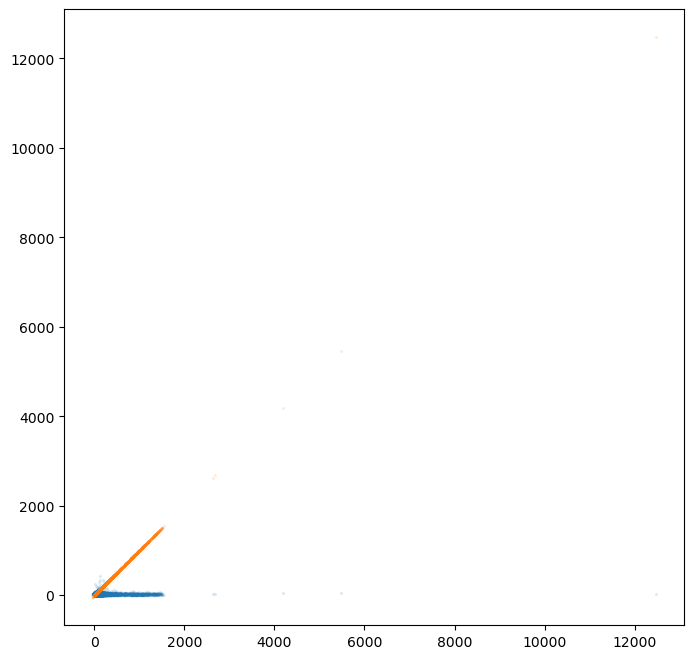

In [69]:
# Load the best model weights
model.load_state_dict(torch.load("best_trip_duration_model.pt", map_location=device))
model.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model(X_val).squeeze()

# Plot predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_val.cpu().numpy(), y_preds.cpu().numpy(), alpha=0.1, s=2, label="Predicted")
plt.scatter(y_val.cpu().numpy(), y_val.cpu().numpy(), alpha=0.1, s=2, label="Actual")
plt.show()


Well that is something of an issue isn't it. My model never really stopped being a straight line. It just never really fit anything at all. If I had more time, I Would try a bart or something and see if it could do better. However, as it stands, I am proud of my data processing.